# PrimeKG Analysis

## Load PrimeKG

In [1]:
from PrimeKG_analysis import *
import sys
sys.path.append('..')
from PrimeKG_utils import *


CSV to pandas Dataframe

In [2]:
import pandas as pd

primekg = pd.read_csv('../PrimeKG.csv', low_memory=False)

primekg.head()

,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source
0,protein_protein,ppi,0,9796,gene/protein,PHYHIP,NCBI,8889,56992,gene/protein,KIF15,NCBI
1,protein_protein,ppi,1,7918,gene/protein,GPANK1,NCBI,2798,9240,gene/protein,PNMA1,NCBI
2,protein_protein,ppi,2,8233,gene/protein,ZRSR2,NCBI,5646,23548,gene/protein,TTC33,NCBI
3,protein_protein,ppi,3,4899,gene/protein,NRF1,NCBI,11592,11253,gene/protein,MAN1B1,NCBI
4,protein_protein,ppi,4,5297,gene/protein,PI4KA,NCBI,2122,8601,gene/protein,RGS20,NCBI


pandas Dataframe to igraph.Graph (undirected)

* create node Dataframe
    <!-- * Concatenates two parts of the KG: 'x' nodes and 'y' nodes.
    * Renames columns to have consistent names (node_id, node_type, node_name, node_source).
    * Removes duplicates and resets the index, creating a 'node_idx' column. -->

In [3]:
nodes = create_primekg_node_df(primekg)
nodes.head()

,node_idx,node_id,node_type,node_name,node_source
0,0,9796,gene/protein,PHYHIP,NCBI
1,1,7918,gene/protein,GPANK1,NCBI
2,2,8233,gene/protein,ZRSR2,NCBI
3,3,4899,gene/protein,NRF1,NCBI
4,4,5297,gene/protein,PI4KA,NCBI


* create edge Dataframe
    <!-- * Merges the original KG with the nodes dataframe twice (once for 'x' nodes, once for 'y' nodes).
    * Renames the merged 'node_idx' columns to 'x_idx' and 'y_idx'.
    * Keeps only relevant columns: relation, display_relation, x_idx, y_idx.
    * Creates a 'combine_idx' column by concatenating x_idx and y_idx as strings. -->

In [4]:
edges = create_primekg_edge_df(primekg, nodes)
edges.head()

,relation,display_relation,x_idx,y_idx
0,protein_protein,ppi,0,8889
1,protein_protein,ppi,1,2798
2,protein_protein,ppi,2,5646
3,protein_protein,ppi,3,11592
4,protein_protein,ppi,4,2122


* create the edge_index
    <!-- * Extracts 'x_idx' and 'y_idx' columns and transposes them to create an edge list. -->

In [5]:
edge_index = create_primekg_edge_index(edges)

* build igraph.Graph()

In [6]:
graph = dfs_to_graph(nodes, edges)

None


## Type distribution

### Node types

In [7]:
print("Total number of nodes: ", len(nodes))
n_node_type = nodes['node_type'].value_counts()
n_node_type

Total number of nodes:  129430


node_type
biological_process    28642
gene/protein          27671
disease               17135
effect/phenotype      15311
anatomy               14035
molecular_function    11169
drug                   7957
cellular_component     4176
pathway                2516
exposure                818
Name: count, dtype: int64

### Edge types

In [8]:
print("Total number of nodes: ", len(edges))
n_edge_type = edges['relation'].value_counts()
n_edge_type

Total number of nodes:  8104838


relation
anatomy_protein_present       3036406
drug_drug                     2672628
protein_protein                642150
disease_phenotype_positive     304034
bioprocess_protein             289610
cellcomp_protein               166804
disease_protein                161322
molfunc_protein                139060
drug_effect                    129568
bioprocess_bioprocess          105772
pathway_protein                 85292
disease_disease                 64718
contraindication                61422
drug_protein                    51306
anatomy_protein_absent          39774
phenotype_phenotype             37472
anatomy_anatomy                 28064
molfunc_molfunc                 27148
indication                      18790
cellcomp_cellcomp                9690
phenotype_protein                6660
off-label use                    5136
pathway_pathway                  5070
exposure_disease                 4608
exposure_exposure                4140
exposure_bioprocess              3250
exp

### Edge distribution between node types

![Node Type Hypergraph](./node_types_hypergraph.png)

Each row shows the number of edges that connect nodes of different types.

In [9]:
links_per_node_t = links_per_node_type(edge_index, nodes)

In [10]:
contrarelation_edges_index = edges[edges['relation']=="indication"].get(['x_idx', 'y_idx']).values
links_per_node_type(contrarelation_edges_index, nodes)

y_node_type,disease,drug
x_node_type,,
disease,0,9395
drug,9395,0


In [11]:
contrarelation_edges_index = edges[edges['relation']=="contraindication"].get(['x_idx', 'y_idx']).values
links_per_node_type(contrarelation_edges_index, nodes)

y_node_type,disease,drug
x_node_type,,
disease,0,30711
drug,30711,0


In [12]:
contrarelation_edges_index = edges[edges['relation']=="off-label use"].get(['x_idx', 'y_idx']).values
links_per_node_type(contrarelation_edges_index, nodes)

y_node_type,disease,drug
x_node_type,,
disease,0,2568
drug,2568,0


How all edges are distributed between node types. Note that the resulting matrix is symmetric.

In [13]:
total_sum = links_per_node_t.sum().sum()

percentage_total = (links_per_node_t / total_sum) * 100
percentage_total.round(3)

y_node_type,anatomy,biological_process,cellular_component,disease,drug,effect/phenotype,exposure,gene/protein,molecular_function,pathway
x_node_type,,,,,,,,,,
anatomy,0.346,0.000,0.000,0.000,0.000,0.000,0.000,18.977,0.000,0.000
biological_process,0.000,1.305,0.000,0.000,0.000,0.000,0.020,1.787,0.000,0.000
cellular_component,0.000,0.000,0.120,0.000,0.000,0.000,0.000,1.029,0.000,0.000
disease,0.000,0.000,0.000,0.799,0.527,1.891,0.028,0.995,0.000,0.000
drug,0.000,0.000,0.000,0.527,32.976,0.799,0.000,0.317,0.000,0.000
effect/phenotype,0.000,0.000,0.000,1.891,0.799,0.462,0.000,0.041,0.000,0.000
exposure,0.000,0.020,0.000,0.028,0.000,0.000,0.051,0.015,0.001,0.000
gene/protein,18.977,1.787,1.029,0.995,0.317,0.041,0.015,7.923,0.858,0.526
molecular_function,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.858,0.335,0.000


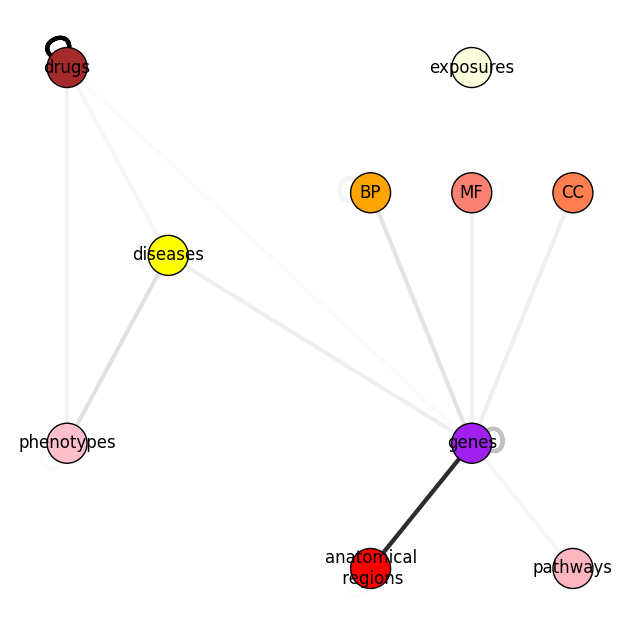

In [14]:
weighed_hypergraph_node_types(percentage_total, 0)

Given a node type for each row, the dataframe shows the distribution of all exiting edges towards the possibile node types.

In [15]:
percentage_link_counts = links_per_node_t.div(links_per_node_t.sum(axis=1), axis=0) * 100

percentage_link_counts.round(3)

y_node_type,anatomy,biological_process,cellular_component,disease,drug,effect/phenotype,exposure,gene/protein,molecular_function,pathway
x_node_type,,,,,,,,,,
anatomy,1.792,0.000,0.000,0.000,0.000,0.000,0.000,98.208,0.000,0.000
biological_process,0.000,41.939,0.000,0.000,0.000,0.000,0.644,57.416,0.000,0.000
cellular_component,0.000,0.000,10.408,0.000,0.000,0.000,0.011,89.581,0.000,0.000
disease,0.000,0.000,0.000,18.836,12.420,44.596,0.671,23.477,0.000,0.000
drug,0.000,0.000,0.000,1.521,95.256,2.309,0.000,0.914,0.000,0.000
effect/phenotype,0.000,0.000,0.000,59.203,25.032,14.479,0.000,1.287,0.000,0.000
exposure,0.000,17.406,0.107,24.679,0.000,0.000,44.344,12.982,0.482,0.000
gene/protein,58.450,5.503,3.169,3.065,0.975,0.127,0.046,24.403,2.642,1.621
molecular_function,0.000,0.000,0.000,0.000,0.000,0.000,0.047,71.886,28.068,0.000


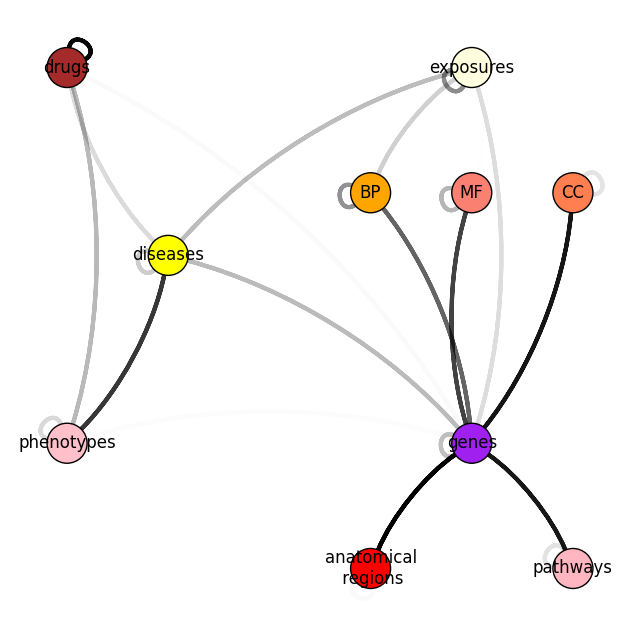

In [16]:
weighed_hypergraph_node_types(percentage_link_counts, 0.2)

## Graph visualization though embedding

/home/luci/.local/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


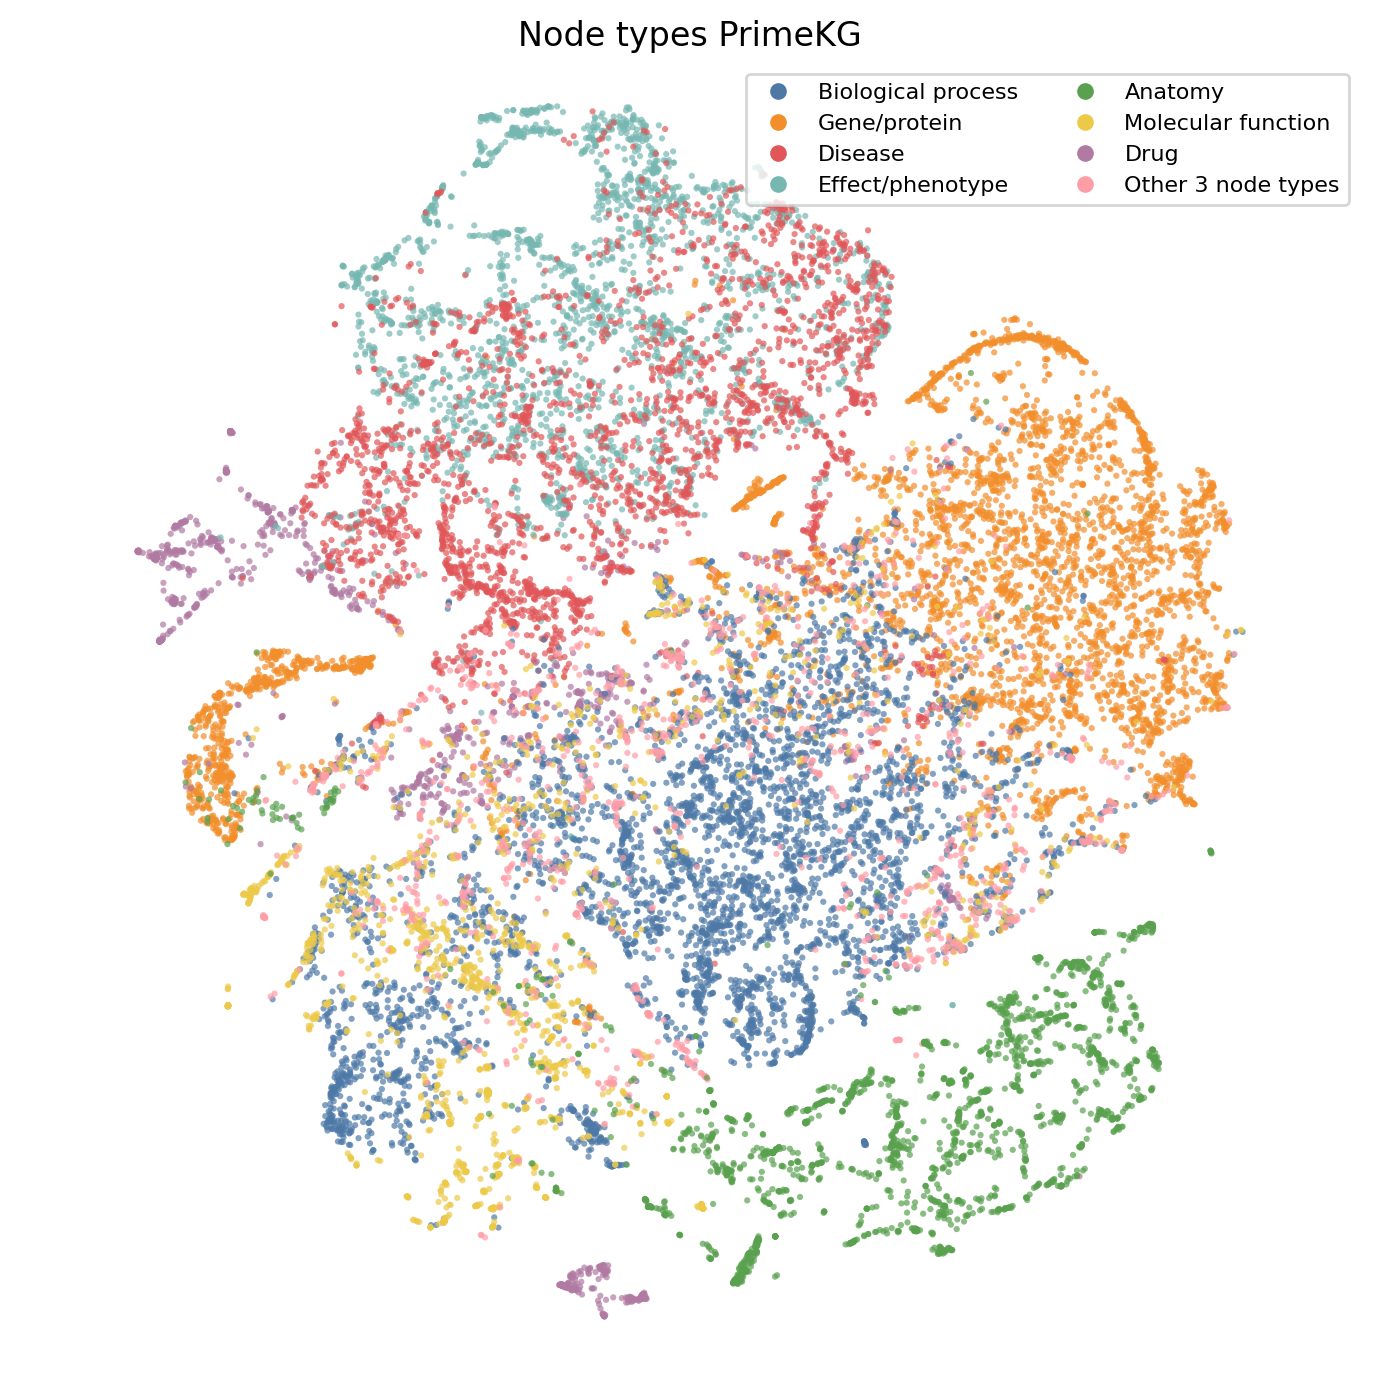

In [18]:
from grape import Graph, GraphVisualizer
from grape.embedders import Node2VecSkipGramEnsmallen

# # Graph sample
# node_sample = nodes.sample(500)
# edge_sample = edges[(edges['x_idx'].isin(node_sample['node_idx'])) & (edges['y_idx'].isin(node_sample['node_idx']))]

g = Graph.from_pd(
    edges_df = edges,
    nodes_df = nodes,
    node_name_column = 'node_idx',
    node_type_column = 'node_type',
    edge_src_column = 'x_idx',
    edge_dst_column = 'y_idx',
    edge_type_column = 'relation',
    directed = False,
    name = 'PrimeKG'
)
embedding=Node2VecSkipGramEnsmallen(
                    embedding_size=10,
                    return_weight=.25,
                    explore_weight=4, 
                    #change_node_type_weight=.0001,
                    #change_edge_type_weight=param[3],
        )
import os
if not os.path.exists('node_embeddings.csv'):
    emb = embedding.fit_transform(g)
    emb_dump = embedding.dump()
    emb_dump['node_embeddings'][0].to_csv('node_embeddings.csv', index=False)
else:
    emb = pd.read_csv('node_embeddings.csv').to_numpy()
    
vis = GraphVisualizer(
            graph=g,
            automatically_display_on_notebooks=False,
            decomposition_method = 'TSNE',
        )
vis.fit_nodes(emb)
vis.plot_node_types()
plt.show()
# nodes_positions = vis._node_decomposition
# nodes_types = vis._get_flatten_multi_label_and_unknown_node_types()

# x=[p[0] for p in nodes_positions]
# y=[p[1] for p in nodes_positions]

# plt.rcdefaults()
# mpl.rcParams.update(mpl.rcParamsDefault)

# fig, ax = plt.subplots()

# plt.scatter(x, y,
#             marker='o',
#             s=10,
#             #s=20*nodes_types, 
#             c=nodes_types, 
#             #cmap=mpl.colormaps['gray'], 
#             alpha=.5)

# ax.set_aspect('equal', 'box')
# ax.set_axis_off()

# fig.tight_layout()

# plt.show()

## Connectivity

### Neighbourhood sizes per type

<class 'NoneType'>


AttributeError: 'NoneType' object has no attribute 'vs'

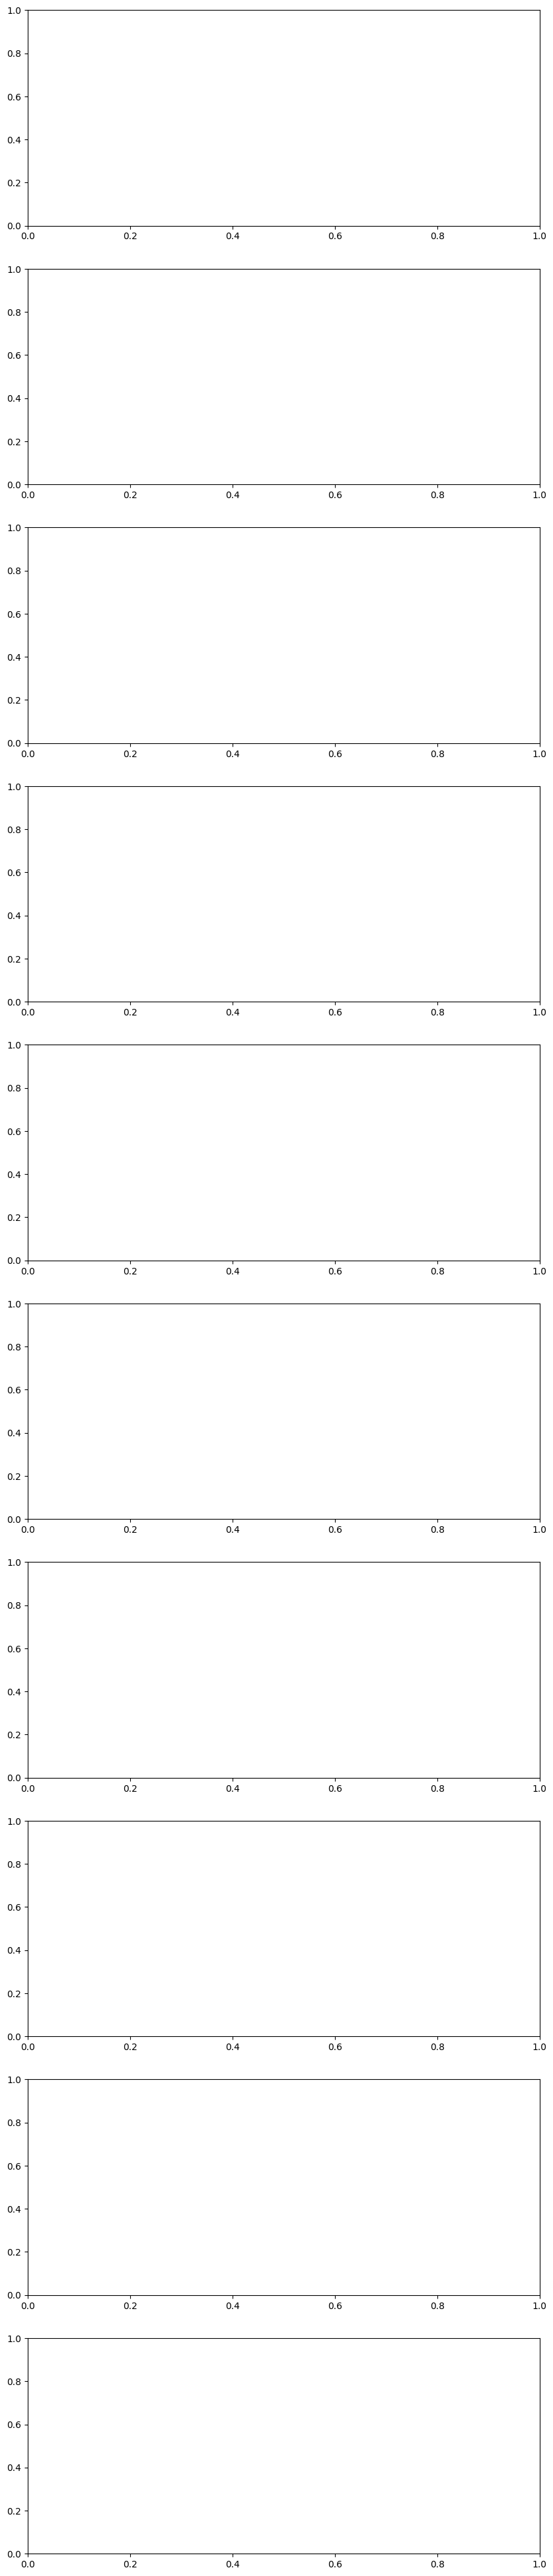

In [19]:
node_types = nodes['node_type'].unique()
print(type(graph))
fig, axes = plt.subplots(len(node_types), 1, figsize=(10, 5*len(node_types)))
for ax, node_type in zip(axes, node_types):
    plot_degree_distribution(ax, graph, node_type)
plt.tight_layout()
plt.show()   

In [ ]:
is_strongly_connected = graph.is_connected(mode="strong")
print(f"Is the graph strongly connected? {is_strongly_connected}")

is_weakly_connected = graph.is_connected(mode="weak")
print(f"Is the graph weakly connected? \t {is_weakly_connected}")

## Clusterability

[igraph.modularity(membership_vector)](https://r.igraph.org/reference/modularity.igraph.html) measures how well a network is divided into communities compared to a random graph with the same degree distribution 
* modularity $\sim 1$ → well formed communities with 
* modularity $\sim 0$ → community structure is weak or indistinguishable from random with modularity

[igraph.community_multilevel](https://igraph.org/c/doc/igraph-Community.html#igraph_community_multilevel) optimize modularity greedily

[igraph.community_label_propagation](https://journals.aps.org/pre/pdf/10.1103/PhysRevE.76.036106) labels spread across neighbours - node labels updated according to random permutation until convergence

[igraph.community_leading_eigenvector](https://igraph.org/c/doc/igraph-Community.html#igraph_community_leading_eigenvector)  maximization of modularity benefit function can be written in terms of the eigenspectrum of a matrix (modularity matrix)




In [ ]:
clustering_methods = lambda graph: [graph.community_multilevel, graph.community_label_propagation, graph.community_leading_eigenvector]

for method in clustering_methods(graph):
    num_clusters, mod = clustering_info(graph, method)
    print(f"{method.__name__}\n---------------------------------\n Number of communities: {num_clusters}\n Modularity score: {mod}\n")

Transitivity: how often nodes that are neighbors of a given node are also neighbors of each other - ratio of triangles vs triplets

In [ ]:
graph.transitivity_undirected()

In [ ]:
graph.transitivity_avglocal_undirected()